In [ ]:
import math 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import re, string, unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from utilities import *
%matplotlib inline
sns.set()
plt.style.use("ggplot")

In [ ]:
# Loading dataframe
outbreaks = pd.read_csv("machine_learning_ready.csv")
#General information about the dataframe
outbreaks= outbreaks.reset_index()
outbreaks.info()

Separation in train and test sets. The train set is going to be used to train and validate de model. The test set is going to be put aside until the end.

In [ ]:
temp_data=outbreaks[['Year', 'Month', 'State', 'Species', 'Location',
       'normalized_food', 'Illnesses', 'Hospitalizations', 'Fatalities',
       'Most_common_Location', 'Most_common_Species','Are_there_Hospitalizations', 'Are_there_Fatalities']]
del outbreaks
outbreaks=temp_data
outbreaks.info()


In [ ]:
# In order tu use train_test_split we create and extra column filled with ones.
extra_column= np.ones(outbreaks.values.shape[0]).reshape(-1,1)
X = outbreaks.values

from sklearn.model_selection import train_test_split
# X_train_val is our train-validate set
X_train_val, X_test, _, _ = train_test_split(X, extra_column,test_size \
                                                    = 0.25, random_state=0)
# outbreaks_train associated dataframe of X_train_val
outbreaks_train = pd.DataFrame(X_train_val, columns=outbreaks.columns) 
# outbreaks_test associated dataframe of X_test
outbreaks_test = pd.DataFrame(X_test, columns=outbreaks.columns ) 

In [ ]:
# scikit-learn k-fold cross-validation
from numpy import array
from random import seed
np.random.seed(12)
from sklearn.model_selection import KFold
# data 
data = X_train_val
# Prepare cross validation and number of splits
n_folds = 3
kfold = KFold(n_folds, shuffle=False, random_state=132)
# pairs of train and validation sets to do cv
data_splits=kfold.split(data)
train_sets= [] # n_folds train  sets
val_sets = [] # n_folds validation  sets
for train_index, val_index in data_splits:
    train_sets.append(data[train_index])
    val_sets.append(data[val_index])
    


In [ ]:
# Useful functions
import copy

# Formating numerical features
def to_float(data,column):
    #Return type float column 
    dataframe= copy.deepcopy(data)
    return dataframe[column].astype("float")


# Divide outbreaks  using the median of Illnesses
def A_lot_of_Ill(column):
    #Convert column Illnesses to categoriacl where median_Log_Ill_train is the threshold   
    out_A_lot_of_Ill = column >= median_Log_Ill_train
    out_A_lot_of_Ill = out_A_lot_of_Ill.astype("int")
    return out_A_lot_of_Ill
    
# Function that produces two classes given a threshold   
def two_classes(data, column,thr=0.0):
    # Return boolean column
    dataframe=copy.deepcopy(data)
    # Boolean column 
    binary_classes= (dataframe[column] > thr).astype("float")
    return binary_classes

# This fuction return the most common classes 
def most_common(data, column,top_classes):
    # Params:
    # top_classes is the number of labels to consider
    
    # Return:
    # A column  with top labels with  more outbreaks
    dataframe = copy.deepcopy(data)
    
    def common_classes(element):
    
        if element in top_classes:
            return element 
        else:
            return "bulk_" + column
        
    most_common_elements =dataframe[column].apply(common_classes)
    return most_common_elements


def not_outliers_column(data, train_set, column,threshold=99.9):
    
    # Return a boolean column where True = not outlier and False= outlier
    #In order to avoid data leakages from  test set, on the column train_set[column]  
    #is calculated the threshold that is 
    #used to classify the points of data[column] in outliers or not.
     
    
    # Params:
    # data is our dataset it could be train, validation or test set
    # train_set is the train dataset 
    # column is the column of interest
    #threshold is the threshold to use
    
    #Return:
    # Boolean numpy array
    
    
    # If column = Fatalities the threshold  is greater
    if column == "Fatalities":
        thr = 99.95
    else:
        thr = threshold
        
    train_data=copy.deepcopy(train_set)
    # Numeric value associated with threshold percent 
    thr_percent = np.percentile(train_data[column],thr)
    
    return (data[column] <= thr_percent)


# pd.get_dummies need that all data have to be in the same dataframe
    
# Encoding categorical variables using get_dummies
def get_dummies(data1,data2):
    # Return one hot encoding for train and val sets
    
    dframe1= copy.deepcopy(data1)
    dframe2= copy.deepcopy(data2)
    
    # concatenating train and val sets
    join=pd.concat([dframe1,dframe2],axis = 0) 
    # Reindexing
    join_reindex= join.reset_index(drop=True,inplace=False)
    # Getting dummies
    dummies= pd.get_dummies(join_reindex,drop_first=True)
    
    #Recovering  the original datasets in term of the dummies
    
    # Dummies for 1st dataset
    df1_dummies= dummies.iloc[:dframe1.shape[0],:]
    
    # Dummies for 2nd dataset.
    #Here, I used reset_index because indexes of the second dataset do not start at 0
    df2_dummies = dummies.iloc[dframe1.shape[0]:,:].reset_index(drop=True,inplace=False)
    
    return df1_dummies, df2_dummies


To avoid data leaking fron validation set to trainig set, we will do all preprocessing steps in each cv fold.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import (BernoulliNB,GaussianNB,MultinomialNB)
from xgboost import XGBClassifier

X_train_sets= [] # List that will contain n_folds  clean  train sets 
X_val_sets= [] # List that will contain n_folds  clean  train sets 
y_train_sets= []
y_val_sets= []
for index in range(n_folds):
    # Steps in each fold
    train ,val , y_train, X_train , y_val , X_val = None,None,None,None,None,None
    
    # Train and val sets for this fold
    train = train_sets[index]
    val = val_sets[index]
    # Train and validation dataframes for this fold 
    train = pd.DataFrame(train, columns=outbreaks_train.columns )    
    val = pd.DataFrame(val, columns=outbreaks_train.columns )
    
    float_columns= ['Illnesses', 'Hospitalizations', 'Fatalities']

    for column in float_columns: 
        train.loc[:,column]= to_float(train,column)
        val.loc[:,column]= to_float(val,column)
      
    # Logarithmic scale for Illenesses
    train["Log_Illnesses"]=np.log(train.Illnesses)
    val["Log_Illnesses"]=np.log(val.Illnesses)
    
    #New columns, two classes: one class describes the outbreaks 
    #with less Illnesses than the median  and the another class 
    #outbreaks with more Illnesses than the median. To evoid data leaking the criteria that define 
    #the clases is calculated only in the train set
    
    # Median for the train set
    global median_Log_Ill_train
    median_Log_Ill_train=train["Log_Illnesses"].median()

    
    train["A_lot_of_Ill"] = A_lot_of_Ill(train["Log_Illnesses"] )
    val["A_lot_of_Ill"] = A_lot_of_Ill(val["Log_Illnesses"])
    

    #Checkpoint
    
    #Passing Hospitalizations and Fatalities to categorical variables.
    train["Are_there_Hospitalizations"] = two_classes(train, "Hospitalizations",thr=0.0)
    val["Are_there_Hospitalizations"] = two_classes(val, "Hospitalizations",thr=0.0)
    # New columns 
    train["Are_there_Fatalities"] = two_classes(train,"Fatalities",  0.0)
    val["Are_there_Fatalities"] = two_classes(val,"Fatalities",  0.0)

    
    
    # Most common  elements for  the features 'Species', 'Location' and  'Food'
  

    categorical_cols = ['Species', 'Location']
    n_classes = 10
    # New columns with the most common entries
    for feature in categorical_cols:
        # Most common elements are generated in the train set
        top=list(train[feature].value_counts().index)[:n_classes]
        train["Most_common_" + feature] = most_common(train,feature,top_classes=top)
        val["Most_common_" + feature] = most_common(val,feature,top_classes=top)
        top = None
        
        

    # Outliers 
    
    # Removal of outliers from numerical columns
    features = ["Hospitalizations","Fatalities","Illnesses"]
    # Creating copies of the data
    not_outliers_train = copy.deepcopy(train)
    not_outliers_val = copy.deepcopy(val)
    
    for feature in features:
        #For each feature outliers for train data are removed
        without_outliers_train= not_outliers_column(not_outliers_train, train
                                              , feature,threshold=99.9)
        #For each feature outliers for validation  data are removed
        without_outliers_val= not_outliers_column(not_outliers_val, train
                                              , feature,threshold=99.9)
        # Saving data in a temporary variable
        temp_not_outliers_train= not_outliers_train.loc[without_outliers_train,:]
        
        temp_not_outliers_val= not_outliers_val.loc[without_outliers_val,:]
        
        #Erasing the  original dataset
        not_outliers_train = None
        not_outliers_val = None
        
        # Transferring temporal values
        not_outliers_train = temp_not_outliers_train.loc[:,:]
        not_outliers_val = temp_not_outliers_val.loc[:,:]
        
        #Cleaning memory
        temp_not_outliers_train = None
        temp_not_outliers_val = None
        
        
        
        
        
       
    # Clean train and validation set
    outbreaks_clasif_train=not_outliers_train[['Year', 'Month', 'State','A_lot_of_Ill', 'Are_there_Hospitalizations',
                                               'Species', 'Location']]
    outbreaks_clasif_val=not_outliers_val[['Year', 'Month', 'State','A_lot_of_Ill', 'Are_there_Hospitalizations',
                                               'Species', 'Location']]
    
    
    
    
    # Getting dummies
    outbreaks_dummies_train= get_dummies(outbreaks_clasif_train,outbreaks_clasif_val)[0]
    outbreaks_dummies_val = get_dummies(outbreaks_clasif_train,outbreaks_clasif_val)[1]
    
    #Now, the dataframe is machine learning ready 
    
    # Separating predictors from the response variable for train and val sets
    y_train = outbreaks_dummies_train['Are_there_Hospitalizations'].values.reshape(-1,1).ravel()
    X_train = outbreaks_dummies_train.drop('Are_there_Hospitalizations', axis=1).values
    y_val = outbreaks_dummies_val['Are_there_Hospitalizations'].values.reshape(-1,1).ravel()
    X_val = outbreaks_dummies_val.drop('Are_there_Hospitalizations', axis=1).values
    
    # Machine learning ready
    #Clean and  set data. n_folds pairs of train and val sets
    X_train_sets.append(X_train)
    y_train_sets.append(y_train)
    X_val_sets.append(X_val)
    y_val_sets.append(y_val)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN, SMOTETomek
#from imblearn.under_sampling import RepeatedEditedNearestNeighbours,TomekLinks,AllKNN,NeighbourhoodCleaningRule,OneSidedSelection
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
from itertools import product

# Classification method
def classifier(method,parameters):
    # Params:
    # method is the classification method to use
    # parameters is the parameters for this method
    
    # Return:
    # classifier object
    
    return method(**parameters)


# Hyperparameters Mesh
def param_grid(dict_parameters):
    # This function takes a dictionary of hyperparameters  and 
    #return all posible combination of them 
    
    #Params:
    # dictionary of parameters,which takes the form: {"parameter_name": values}
    
    # Return:
    #List of all comninations of parameters, where each element of the list is a dictionary
    
    # Initializations
    
    # List of all comninations of parameters
    hyperparameter_combinations=[]
    # List parameter values
    params =[]
    # List parameter names
    param_names =[]
    
    # Filling lists
    for key,value in dict_parameters.items():
        param_names.append(key)
        params.append(value)
    # All combinations
    combination_params = list(product(*params))
    # Filling the list with all the combinations where each element of this list is a dictionary
    for combination in combination_params:
        hyperparameter= dict(zip(param_names,combination))
        hyperparameter_combinations.append(hyperparameter)
    # List of dictionaries
    return hyperparameter_combinations 



#Evaluation metrics for all classes
def metrics(y,y_pred):
    # Compare predicted vs real values and return several evaluation metrics for each class.
    
    # Return:
    #tuple with class0,class1,avg, accuracy  Where class0 and class1 return class label, 
    #precision, recal, f1_score for each of them. 
    #avg is the average of precision, recal, f1_score and accuracy is the accuracy.
    
    # Accuracy score
    accuracy =accuracy_score(y, y_pred)
    
    # classification report
    classif_report= classification_report(y, y_pred,digits=5)

    #------------------------------------------------------------------
    #Extract all float values. The first 4 elements are associated to class 0
    #and the labels are as follow: class, precision, recall , f1_score
    #For class1 is the same. 
    #The last 3 element are the average 
    
    # Extracting float numbers
    metrics_classes = re.findall("\d+\.\d+",classif_report)
    
    #------------------------------------------------------------------
    #For class0
    
    #List with class label, precision, recal, f1_score
    class0_str= metrics_classes[:4] 
    
    #------------------------------------------------------------------
    #For class1
    
    #List with class label, precision, recal, f1_score
    class1_str = metrics_classes[4:8]
    #------------------------------------------------------------------
    # average
    
    avg_str = metrics_classes[8:]
    
    #Converting from string to float
    #------------------------------------------------------------------
    #For class0
    class0= list(map(lambda x: float(x),class0_str))
    
    #------------------------------------------------------------------
    #For class1
    class1= list(map(lambda x: float(x),class1_str))
    
    # average
    avg=list(map(lambda x: float(x),avg_str))
    
   
    return class0, class1, avg, accuracy


#SMOTE: over-sampling method that creates synthetic samples of the 
#minority class(In our case, outbtreaks with hospitalizations)

def sampling(X_set,y_set, balanced=False):
    # Creates synthetic samples of the minority class
    # Params:
    # X_set,y_set are the data
    # If balanced = True  SMOTE is used
    
    # Return:
    # Over-sampled dataset: x_res, y_res
    # New minority class percentage
    
    
    # Creating copies of the data
    X_data, y_data = copy.deepcopy(X_set),copy.deepcopy(y_set)
    
    x_res, y_res = None,None
    
    # SMOTE object
    sm = SMOTEENN(ratio = "auto")
    
    # Condition to use SMOTE   
    if balanced== True:
        #Sampling and balancing the train data
        x_res, y_res = sm.fit_sample(X_data, y_data)
    else:
        x_res, y_res= X_data, y_data
        
    return x_res, y_res, 100.0*y_res.sum()/y_res.shape[0]



#Evaluation metrics for each combination of parameters       
def scores_grid(method=BernoulliNB, dict_parameters={'alpha': [1]}):
    #For a given method and set of parameters, this function returns several 
    #evaluation metrics for each combination of these parameters.
    
    # Params:
    # method is our classification method
    # dict_parameters are the parameters
    
    #Return:
    # class0_metrics are  class label, precision, recal, f1_score, accuracy for each combination of parameters
    # class1_metrics are the same that class0_metrics but for class 0. Finally, accuracy is 2D 
    #array where first column is the accuracy for training set and 2nd column is for the validation set
    
    
    # Evaluation metrics for each combination of parameters
    # Initialization of the lists with the evaluation metrics
    
    #Class 0
    class0_metrics =[]
    #Class 1
    class1_metrics=[]
    
    # Accuracy
    accuracy=[]
    
    #Loop for all combination of parameters
    for param_set in param_grid(dict_parameters):
        #Classifier
        clf= classifier(method,param_set)
        
        # Initialization of metrics  per set of parameters
        
        sum_scores_recall_train_c1, sum_scores_recall_val_c1= (0,0)
        sum_scores_f1_train_c1, sum_scores_f1_val_c1= (0,0)
        
        sum_scores_recall_train_c0, sum_scores_recall_val_c0= (0,0)
        sum_scores_f1_train_c0, sum_scores_f1_val_c0= (0,0)
        
        # Accuracy
        sum_scores_accuracy_train,sum_scores_accuracy_val = (0,0)
        
        # Folds
        for fold in range(n_folds):
            # Data
            X_train, y_train, X_val, y_val =None,None,None,None
            y_pred_train,y_pred_val,val_scores,train_scores = None,None,None,None
            
            # Data for fold 
            X_train, y_train = X_train_sampled[fold], y_train_sampled[fold]
            X_val, y_val= X_val_sets[fold], y_val_sets[fold]
            
            # Fit and predict   
            clf.fit(X_train, y_train)
            y_pred_train = clf.predict(X_train_sets[fold])
            y_pred_val = clf.predict(X_val)
            
            # Metrics
            val_scores = metrics(y_val,y_pred_val)
            train_scores = metrics(y_train_sets[fold],y_pred_train)
            
            #class 1------------------------------------------------------
            #recall
            sum_scores_recall_val_c1 +=  val_scores[1][2] 
            sum_scores_recall_train_c1 +=  train_scores[1][2]
            
            #f1
            sum_scores_f1_val_c1 +=val_scores[1][3]
            sum_scores_f1_train_c1 +=train_scores[1][3]
            
             #class 0 ------------------------------------------------------
            #Recall
            sum_scores_recall_val_c0 +=  val_scores[0][2]
            sum_scores_recall_train_c0 +=  train_scores[0][2]
            #f1
            sum_scores_f1_train_c0 +=train_scores[0][3]
            sum_scores_f1_val_c0 +=val_scores[0][3]
            
            #Accuracy
            sum_scores_accuracy_train += train_scores[3]
            sum_scores_accuracy_val +=val_scores[3]
            
        
        # Metrics  for each  set of parameters
        #Class0 ------------------------------------------------------
        
        #Recall
        recall_val_c0 = 100.0*sum_scores_recall_val_c0/n_folds
        recall_train_c0 = 100.0*sum_scores_recall_train_c0/n_folds
        
        #f1
        f1_val_c0 = 100.0*sum_scores_f1_val_c0/n_folds
        f1_train_c0 = 100.0*sum_scores_f1_train_c0/n_folds
        
        # List of metrics 
        class0_metrics.append([recall_train_c0,recall_val_c0,\
                               f1_train_c0,f1_val_c0,param_set])
        
        
        
        #Class1 ------------------------------------------------------
        #Recall
        recall_val_c1 = 100.0*sum_scores_recall_val_c1/n_folds
        recall_train_c1 = 100.0*sum_scores_recall_train_c1/n_folds
        #f1
        f1_val_c1 = 100.0*sum_scores_f1_val_c1/n_folds
        f1_train_c1 = 100.0*sum_scores_f1_train_c1/n_folds
        
        # List of metrics 
        class1_metrics.append([recall_train_c1,recall_val_c1,\
                                f1_train_c1,f1_val_c1,param_set])
        
        accuracy_train =100.0* sum_scores_accuracy_train/n_folds
        accuracy_val = 100.0* sum_scores_accuracy_val/n_folds
        accuracy.append([accuracy_train,accuracy_val,param_set])
        
        
        
        
    return np.array(class0_metrics), np.array(class1_metrics),np.array(accuracy)

# Dataframe with evaluation metrics for each parameter
def metrics_dataframe(metrics_class):
    
    # Params:
    # metrics_class is class label, precision, recal, f1_score for chosen class
    
    #Return:
    # Dataframe with columns parameters, recall_train, recall_val, f1_train, f1_val
    
    
    # Dataframe with the metrics values 
    metrics_df=pd.DataFrame(metrics_class[:,:-1],\
                            columns=["recall_train","recall_val","f1_train","f1_val"])
    # Parameters values
    param_dicts=metrics_class[:,-1]
    # Dataframe  of parameters
    parameters_df= pd.DataFrame.from_dict(list(param_dicts))
    
    return pd.concat([parameters_df,metrics_df],axis=1)


# Dataframe with the accuracy metric for each parameter
def acc_plot(acc_array):
    # Create a dataframe with accuracy for train and validation 
    
    # Params:
    # acc_array contains the accuracy for train and validation datasets for each combination of parameters
    
    #Return:
    # Dataframe with columns parameters, accuracy train, accuracy validation and the columns of parameters
    

    
    # Accuracy for training
    acc_values=pd.DataFrame(acc_array[2][:,:2],columns=['acc_train','acc_val'])

    # Parameters values
    parameter_values = pd.DataFrame(list(acc_array[2][:,-1]))
    
    # concatenate accuracy values and parameters
    acc_dataframe = pd.concat([parameter_values, acc_values],axis=1)
    return  acc_dataframe



def plot_metric_behaviour(dataframe,var_param,metric,fixed_param=None,step=3):
    
    # Plots of var_param vs metric for different values of fixed_param
    
    #Params:
    
    # dataframe is a dataframe with the evaluation metric for a given class
    # var_param is the parameter to be plotted with respect to metric
    #metric is evaluation metric of interest
    # fixed_param is the parameter that is fixed for each var_param curve.
    # If the classifier has only one hyperparameter fixed_param =None
    #step defines the values to be used of fixed_param
    
    #Return:
    #Plot of var_param vs metric for each fixed_param
    
    
    df_metrics = dataframe.copy()
    
    # Condition that asks if the classifier has more than one hyperparameter
    if fixed_param != None:
        for fixed_p in df_metrics[fixed_param].unique()[::step]:
            
            temp_fixed_p = None
            # subset od data for each fixed_param
            temp_fixed_p= df_metrics[df_metrics[fixed_param]==fixed_p]
            
            label=  fixed_param  + "_ " + str(fixed_p)
            # Plots
            plt.plot(temp_fixed_p[var_param],temp_fixed_p[metric],label=label)
        
        
    else:
        # This case is when the classifier has only one hyperparameter
        plt.plot(df_metrics[var_param],df_metrics[metric],label=var_param)
    
    #Plot labels
    plt.xlabel(var_param)
    plt.ylabel(metric + " (%)")
    plt.title(metric)
    plt.legend()
    plt.show()
    

    
def plot_learning_curve(dataframe,var_param, metric,fixed_param=None,value=None):
    
    # Plots of var_param vs metric for different values of fixed_param
    
    #Params:
    
    # dataframe is a dataframe with the evaluation metric for a given class
    # var_param is the parameter to be plotted with respect to metric
    #metric is evaluation metric of interest
    # fixed_param is the parameter that is fixed for each  curve.
    # If the classifier has only one hyperparameter fixed_param =None
    #value is the value of fixed_param
    
    #Return:
    #Plot with learning curves, train and validation sets. Each curve is a plot of 
    #var_param vs metric for the same fixed_param 
    
    df_metrics = dataframe.copy()
    if value != None:
        temp_fixed_p= df_metrics[df_metrics[fixed_param]==value]
        title= metric + " with " + fixed_param + " = " + str(value)
        # Train metric
        plt.plot(temp_fixed_p[var_param],temp_fixed_p[metric +"_train" ],label="train")
        # Validation metric
        plt.plot(temp_fixed_p[var_param],temp_fixed_p[metric +"_val" ],label="val")

    else:
        title= metric 
        # Train metric
        plt.plot(df_metrics[var_param],df_metrics[metric +"_train" ],label="train")
        # Validation metric
        plt.plot(df_metrics[var_param],df_metrics[metric +"_val" ],label="val")

        
    #Plot labels   
    plt.xlabel(var_param)
    plt.ylabel(metric + " (%)")
    plt.title(title)
    plt.legend()
    plt.show()
        
        

In [ ]:
np.random.seed(123)
global X_train_sampled
global y_train_sampled

# Sampled train sets 
X_train_sampled, y_train_sampled =[],[]

#Minority class percentage list
ratio_list = []
np.random.seed(123)
for fold in range(n_folds):
    
    X_temp,y_temp=None,None
    # Use SMOTE(over-sampling method)  if balanced=False
    X_temp,y_temp,ratio=sampling(X_train_sets[fold],y_train_sets[fold], balanced=False)
    
    # Append to a over-sampled dataset
    X_train_sampled.append(X_temp)
    y_train_sampled.append(y_temp)
    
    #Minority class percentage
    ratio_list.append(ratio)

Let us see the performance of our model with Random forest

In [10]:
# Random forest hyperparameters
n_estimators =list(map(np.int, np.logspace(1,1.8,2)))

max_depth =list(set(map(np.int, np.linspace(8,15,30))))

In [11]:
# Random forest evaluation metrics
# rf index 0 is metrics for class 0, index 1 is for class 1 and index 2 is the accuracy
rf= scores_grid(RandomForestClassifier,{'n_estimators':n_estimators ,'max_depth': max_depth})

In [12]:
# Dataframe of parameters, recall and f_values for class 0
rf_metrics= metrics_dataframe(rf[0])
rf_metrics.head()

The graphs below show how metrics change with the parameters. 

In [13]:
plot_metric_behaviour(rf_metrics,"max_depth", "recall_train","n_estimators",2)

Learning curves

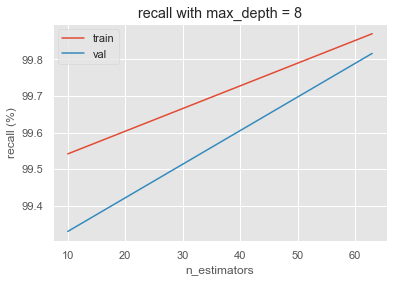

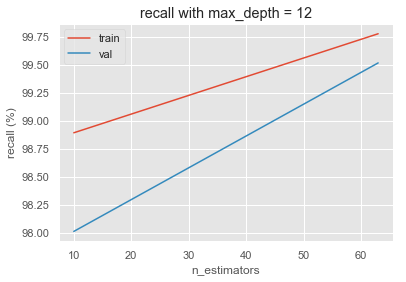

In [14]:
for param in max_depth[::4]:
    plot_learning_curve(rf_metrics,"n_estimators", "recall","max_depth",param)

Let us use a baseline model where all outbreaks cause hospitalizations.


In [15]:
# In this case the accuracy of such model is calculated as follow
base_acc =100.0*(1-outbreaks_train.Are_there_Hospitalizations.sum()/outbreaks_train.shape[0])

print('Baseline model: outbreaks without hosp, accuracy: {:.2f}%.'.format(base_acc))



Baseline model: outbreaks without hosp, accuracy: 72.37%.


In [16]:
# Dataframe with accuracy for each set of parameters
acc_plot(rf)

,max_depth,n_estimators,acc_train,acc_val
0,8,10,74.1048,73.6318
1,9,10,73.8948,73.3021
2,10,10,74.2416,73.4285
3,11,10,75.2153,74.1708
4,12,10,76.1751,74.5001
5,13,10,76.6797,74.7526
6,14,10,76.2871,74.4304
7,15,10,77.6497,74.8086
8,8,63,73.4185,73.3022
9,9,63,73.6742,73.5122


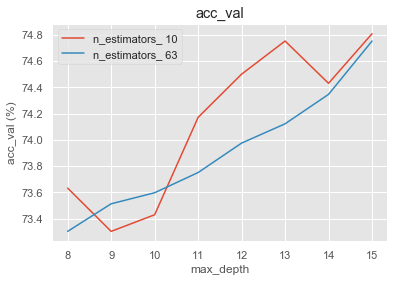

In [17]:
# Plot of accuracy 
plot_metric_behaviour(acc_plot(rf),'max_depth','acc_val','n_estimators',step=1)

Here, the accuracy increases by 2% with respect to baseline model.

Let us assess the Naive Bayes method.

In [18]:
# Parameters
params= np.linspace(0.01,1.0,10)
# Model
ber= scores_grid(BernoulliNB,{"alpha":params})

In [19]:
# Dataframe of metrics
ber_metrics= metrics_dataframe(ber[0])
ber_metrics.head()

,alpha,recall_train,recall_val,f1_train,f1_val
0,0.01,90.303,89.1727,85.5737,84.6277
1,0.12,90.3373,89.308,85.5663,84.69
2,0.23,90.3997,89.376,85.5657,84.7037
3,0.34,90.4773,89.4633,85.5507,84.7437
4,0.45,90.525,89.531,85.5453,84.7537


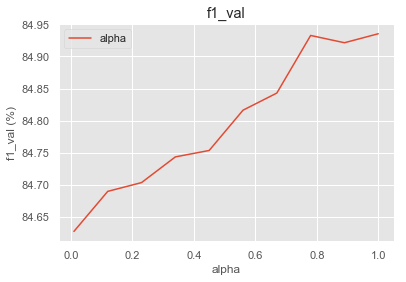

In [20]:
# Plot f1 score for validation data
plot_metric_behaviour(ber_metrics, "alpha", "f1_val",None,2)

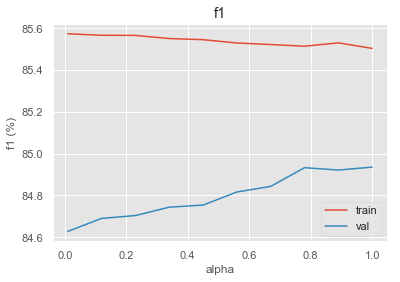

In [21]:
#Learning curve for f1 score
plot_learning_curve(ber_metrics,"alpha", "f1",None,None)

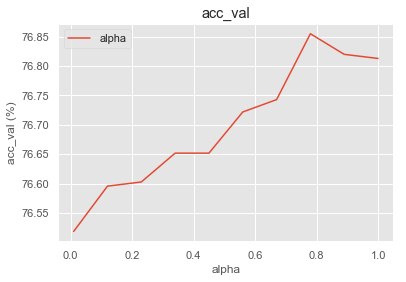

In [22]:
# Plot of accuracy 
plot_metric_behaviour(acc_plot(ber),'alpha','acc_val',step=1)

Here, the accuracy increases by 4% with respect to baseline model.

Logistic regression.

In [23]:
# Parameters
Cs= np.linspace(0.1,10.0,10)

plty= ["l1","l2"]
# Logistic regression algorithm
lreg= scores_grid(LogisticRegression,{"penalty":plty,"C":Cs})

In [24]:
# Dataframe of metrics
lreg_metrics= metrics_dataframe(lreg[0])
lreg_metrics.head()

,C,penalty,recall_train,recall_val,f1_train,f1_val
0,0.1,l1,93.977,93.9403,85.2893,85.1777
1,1.2,l1,92.7973,92.3467,85.7797,85.2527
2,2.3,l1,92.826,92.123,86.1127,85.1683
3,3.4,l1,92.9087,91.9967,86.1867,85.1473
4,4.5,l1,92.9133,91.9673,86.2047,85.1433


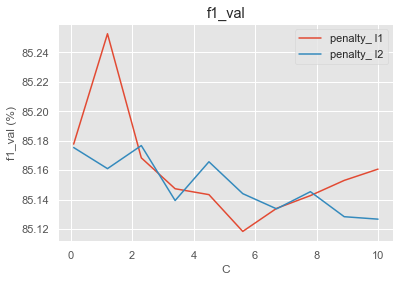

In [25]:
#Plot of metrics for different parameters 
plot_metric_behaviour(lreg_metrics,"C", "f1_val","penalty",1)

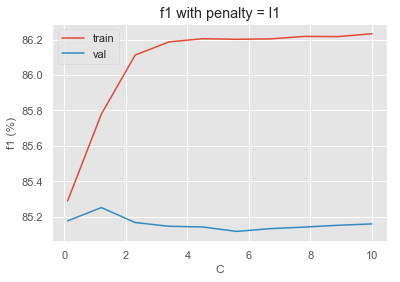

In [26]:
#Learning curve
plot_learning_curve(lreg_metrics,"C", "f1","penalty","l1")

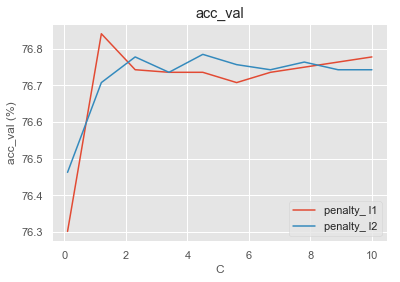

In [27]:
# Plot of accuracy 
plot_metric_behaviour(acc_plot(lreg),'C','acc_val','penalty',step=1)

This result is similar to Naive Bayes case.

Let us evaluate the performance of these models in the test set

In [28]:
test_set = copy.deepcopy(outbreaks_test)
train_set = copy.deepcopy(outbreaks_train)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14308 entries, 0 to 14307
Data columns (total 13 columns):
Year                          14308 non-null object
Month                         14308 non-null object
State                         14308 non-null object
Species                       14308 non-null object
Location                      14308 non-null object
normalized_food               14308 non-null object
Illnesses                     14308 non-null object
Hospitalizations              14308 non-null object
Fatalities                    14308 non-null object
Most_common_Location          14308 non-null object
Most_common_Species           14308 non-null object
Are_there_Hospitalizations    14308 non-null object
Are_there_Fatalities          14308 non-null object
dtypes: object(13)
memory usage: 1.4+ MB


In [29]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Data columns (total 13 columns):
Year                          4770 non-null object
Month                         4770 non-null object
State                         4770 non-null object
Species                       4770 non-null object
Location                      4770 non-null object
normalized_food               4770 non-null object
Illnesses                     4770 non-null object
Hospitalizations              4770 non-null object
Fatalities                    4770 non-null object
Most_common_Location          4770 non-null object
Most_common_Species           4770 non-null object
Are_there_Hospitalizations    4770 non-null object
Are_there_Fatalities          4770 non-null object
dtypes: object(13)
memory usage: 484.5+ KB


In [30]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14308 entries, 0 to 14307
Data columns (total 13 columns):
Year                          14308 non-null object
Month                         14308 non-null object
State                         14308 non-null object
Species                       14308 non-null object
Location                      14308 non-null object
normalized_food               14308 non-null object
Illnesses                     14308 non-null object
Hospitalizations              14308 non-null object
Fatalities                    14308 non-null object
Most_common_Location          14308 non-null object
Most_common_Species           14308 non-null object
Are_there_Hospitalizations    14308 non-null object
Are_there_Fatalities          14308 non-null object
dtypes: object(13)
memory usage: 1.4+ MB


In [31]:
numeric_cols= ['Illnesses', 'Hospitalizations', 'Fatalities','Are_there_Hospitalizations','Are_there_Fatalities']
for column in numeric_cols:
    train_set.loc[:,column]=to_float(train_set,column)
    test_set.loc[:,column]=to_float(test_set,column)

test_set.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Data columns (total 13 columns):
Year                          4770 non-null object
Month                         4770 non-null object
State                         4770 non-null object
Species                       4770 non-null object
Location                      4770 non-null object
normalized_food               4770 non-null object
Illnesses                     4770 non-null float64
Hospitalizations              4770 non-null float64
Fatalities                    4770 non-null float64
Most_common_Location          4770 non-null object
Most_common_Species           4770 non-null object
Are_there_Hospitalizations    4770 non-null float64
Are_there_Fatalities          4770 non-null float64
dtypes: float64(5), object(8)
memory usage: 484.5+ KB


In [32]:
train_set["Log_Illnesses"]=np.log(train_set.Illnesses)
test_set["Log_Illnesses"]=np.log(test_set.Illnesses)

median_Log_Ill_train=train_set["Log_Illnesses"].median()


train_set["A_lot_of_Ill"] = A_lot_of_Ill(train_set["Log_Illnesses"])
test_set["A_lot_of_Ill"] = A_lot_of_Ill( test_set["Log_Illnesses"])
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Data columns (total 15 columns):
Year                          4770 non-null object
Month                         4770 non-null object
State                         4770 non-null object
Species                       4770 non-null object
Location                      4770 non-null object
normalized_food               4770 non-null object
Illnesses                     4770 non-null float64
Hospitalizations              4770 non-null float64
Fatalities                    4770 non-null float64
Most_common_Location          4770 non-null object
Most_common_Species           4770 non-null object
Are_there_Hospitalizations    4770 non-null float64
Are_there_Fatalities          4770 non-null float64
Log_Illnesses                 4770 non-null float64
A_lot_of_Ill                  4770 non-null int64
dtypes: float64(6), int64(1), object(8)
memory usage: 559.1+ KB


In [33]:
train_set.drop(columns=["Log_Illnesses"],inplace=True)
test_set.drop(columns=["Log_Illnesses"],inplace=True)

train_set.drop(columns=["Most_common_Location"],inplace=True)
test_set.drop(columns=["Most_common_Location"],inplace=True)
train_set.drop(columns=["Most_common_Species"],inplace=True)
test_set.drop(columns=["Most_common_Species"],inplace=True)



In [34]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Data columns (total 12 columns):
Year                          4770 non-null object
Month                         4770 non-null object
State                         4770 non-null object
Species                       4770 non-null object
Location                      4770 non-null object
normalized_food               4770 non-null object
Illnesses                     4770 non-null float64
Hospitalizations              4770 non-null float64
Fatalities                    4770 non-null float64
Are_there_Hospitalizations    4770 non-null float64
Are_there_Fatalities          4770 non-null float64
A_lot_of_Ill                  4770 non-null int64
dtypes: float64(5), int64(1), object(6)
memory usage: 447.3+ KB


In [35]:
categorical_features=['Species', 'Location']
for feature in categorical_features:
    top_classes=train_set[feature].value_counts().index[:10]
    label= 'Most_common_' + feature
    train_set[label] = most_common(train_set, feature,top_classes)
    test_set[label] = most_common(test_set, feature,top_classes)      

In [36]:
test_set.head()

,Year,Month,State,Species,Location,normalized_food,Illnesses,Hospitalizations,Fatalities,Are_there_Hospitalizations,Are_there_Fatalities,A_lot_of_Ill,Most_common_Species,Most_common_Location
0,2011,March,IN,norovirus,restaurant - sit-down dining,stuffing turkey,2.0,1.0,0.0,1.0,0.0,0,norovirus,restaurant - sit-down dining
1,2009,May,KS,salmonella enterica,"restaurant - ""fast-food""(drive up service or p...",burrito,2.0,0.0,0.0,0.0,0.0,0,salmonella enterica,"restaurant - ""fast-food""(drive up service or p..."
2,2003,November,HI,scombroid toxin,restaurant - other or unknown type,fish mahi mahi,3.0,0.0,0.0,0.0,0.0,0,scombroid toxin,restaurant - other or unknown type
3,2008,April,FL,norovirus genogroup ii,restaurant - other or unknown type,coleslaw,84.0,2.0,0.0,1.0,0.0,1,norovirus genogroup ii,restaurant - other or unknown type
4,2005,February,OH,other - chemical/toxin,other,peanut,2.0,0.0,0.0,0.0,0.0,0,bulk_Species,other


In [37]:
# Outliers 
    
# Removal of outliers from numerical columns
features = ["Hospitalizations","Fatalities","Illnesses"]
# Creating copies of the data
not_outliers_train = copy.deepcopy(train_set)
not_outliers_test = copy.deepcopy(test_set)
    
for feature in features:
    #For each feature outliers for train data are removed
    without_outliers_train= not_outliers_column(not_outliers_train, not_outliers_train
                                              , feature,threshold=99.9)
    #For each feature outliers for test  data are removed
    without_outliers_test= not_outliers_column(not_outliers_test, not_outliers_train
                                              , feature,threshold=99.9)
    # Saving data in a temporary variable
    temp_not_outliers_train= not_outliers_train.loc[without_outliers_train,:]
        
    temp_not_outliers_test= not_outliers_test.loc[without_outliers_test,:]
        
    #Erasing the  original dataset
    not_outliers_train = None
    not_outliers_test = None
        
    # Transferring temporal values
    not_outliers_train = temp_not_outliers_train.loc[:,:]
    not_outliers_test = temp_not_outliers_test.loc[:,:]
        
    #Cleaning memory
    temp_not_outliers_train = None
    temp_not_outliers_test = None
        

In [38]:
not_outliers_train.drop(columns=["Illnesses"],inplace=True)
not_outliers_test.drop(columns=["Illnesses"],inplace=True)
not_outliers_train.drop(columns=["Hospitalizations"],inplace=True)
not_outliers_test.drop(columns=["Fatalities"],inplace=True)
not_outliers_test.drop(columns=["Hospitalizations"],inplace=True)
not_outliers_train.drop(columns=["Fatalities"],inplace=True)
not_outliers_train.drop(columns=["Species"],inplace=True)
not_outliers_test.drop(columns=["Species"],inplace=True)
not_outliers_train.drop(columns=["Location"],inplace=True)
not_outliers_test.drop(columns=["Location"],inplace=True)
not_outliers_train.drop(columns=["normalized_food"],inplace=True)
not_outliers_test.drop(columns=["normalized_food"],inplace=True)


In [39]:
not_outliers_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4760 entries, 0 to 4769
Data columns (total 8 columns):
Year                          4760 non-null object
Month                         4760 non-null object
State                         4760 non-null object
Are_there_Hospitalizations    4760 non-null float64
Are_there_Fatalities          4760 non-null float64
A_lot_of_Ill                  4760 non-null int64
Most_common_Species           4760 non-null object
Most_common_Location          4760 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 334.7+ KB


In [40]:
dummies=get_dummies(not_outliers_train,not_outliers_test)

dummies_train_set= dummies[0]
dummies_test_set= dummies[1]
    
# Separating predictors from the response variables for train and val sets
y_tr = dummies_train_set['Are_there_Hospitalizations'].values.reshape(-1,1).ravel()
X_tr = dummies_train_set.drop('Are_there_Hospitalizations', axis=1).values
y_tst = dummies_test_set['Are_there_Hospitalizations'].values.reshape(-1,1).ravel()
X_tst =dummies_test_set.drop('Are_there_Hospitalizations', axis=1).values


In [41]:
reg= LogisticRegression(penalty='l1')

reg.fit(X_tr, y_tr)
# Predict the labels of the test set: y_pred
y_pred = reg.predict(X_tst)

print(classification_report(y_tst, y_pred,digits=2))


             precision    recall  f1-score   support

        0.0       0.78      0.93      0.85      3464
        1.0       0.62      0.32      0.42      1296

avg / total       0.74      0.76      0.73      4760



In [42]:
accuracy_score(y_tst, y_pred)

0.7623949579831932